In [153]:
import os

import copy
import random
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd 

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, auc #, roc_curve, precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as st
from scipy.stats import norm
from tabulate import tabulate

from logging_utils import *
from logging_utils import myLogger, print_log, close_loggers 

from plot_utils import plot_mean_ROC, plot_mean_PR
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import scipy.stats as st
from scipy.stats import t
from scipy import stats

In [154]:
SEED = 1970
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

color_index = list(mcolors.CSS4_COLORS)
colors = mcolors.CSS4_COLORS

data_path = './data/'
mean_metrics = 'mean_metrics_inferred_combo.csv'
# mean_metrics_VA = 'mean_metrics_231231.csv'
mean_metrics_VA = 'mean_metrics_inferred_combo_VA.csv'

mean_metrics_cols = ['date', 'model', 'image_size', 'batch_size', 'channel', 'test_set','roc_auc', 'pr_auc', 'f1', 'precision', 'recall']
metrics_cols = ['roc_auc', 'pr_auc', 'f1', 'precision', 'recall']
metric_name = ['ROC AUC', 'PR AUC', 'F1', 'Precision', 'Recall']
test_label = ['test_loc']
# test_label = ['test_loc', 'test_NoL']
test_classes = {'test_loc' : [9554, 1171]}
# test_classes = {'test_loc' : [5812, 336], 'test_NoL' : [3742, 835]}

# channel_label = ['RGB', '3', 'EI', 'MI', '5']
channel_label = ['RGB', 'HSV', 'EI', 'MI', '5']
channel_label_alt = ['RGB', 'HSV', 'HSV + EI', 'HSV + MI', 'HSV + EI + MI']

diff_metrics_cols = [ 'diff % roc_auc ', 'diff % pr_auc', 'diff % f1', 'diff % precision', 'diff % recall']

In [155]:
diff_metrics_combo_set = 'Multi_channel_models_diff_analysis_phase2.csv'

In [156]:
df_diff_metrics = pd.read_csv(f'{data_path}/{diff_metrics_combo_set}')
df_diff_metrics.shape

(115, 22)

In [157]:
df_diff_metrics.loc[df_diff_metrics.channel == '3', 'channel'] = 'HSV'

In [158]:
df_diff_metrics.head(5)

,date,model,image_size,batch_size,channel,roc_auc,diff roc_auc,diff % roc_auc,pr_auc,diff pr_auc,...,diff f1,diff % f1,precision,diff precision,diff % precision,recall,diff recall,diff % recall,uuid,drop_luminance
0,20231206,v1b1,256,64,RGB,0.8041,NaN,NaN,0.3760,NaN,...,NaN,NaN,0.3228,NaN,NaN,0.5167,NaN,NaN,6b8da835-8e14-4efb-ba53-38222eedf65e,False
1,20231206,v1b1,256,64,HSV,0.7841,-0.0199,-0.0254,0.3522,-0.0238,...,-0.0162,-0.0424,0.3023,-0.0205,-0.0679,0.5158,-0.0009,-0.0017,6b8da835-8e14-4efb-ba53-38222eedf65e,False
2,20231206,v1b1,256,64,EI,0.7922,-0.0118,-0.0149,0.3534,-0.0226,...,-0.0138,-0.0360,0.3004,-0.0224,-0.0746,0.5303,0.0137,0.0258,6b8da835-8e14-4efb-ba53-38222eedf65e,False
3,20231206,v1b1,256,64,MI,0.7864,-0.0177,-0.0225,0.3506,-0.0254,...,-0.0192,-0.0508,0.2933,-0.0295,-0.1007,0.5320,0.0154,0.0289,6b8da835-8e14-4efb-ba53-38222eedf65e,False
4,20231206,v1b1,256,64,5,0.7922,-0.0119,-0.0150,0.3632,-0.0128,...,-0.0093,-0.0241,0.2971,-0.0258,-0.0868,0.5594,0.0427,0.0763,6b8da835-8e14-4efb-ba53-38222eedf65e,False


In [159]:
diff_columns = df_diff_metrics.columns.tolist()
print(diff_columns)

['date', 'model', 'image_size', 'batch_size', 'channel', ' roc_auc ', 'diff roc_auc', 'diff % roc_auc ', ' pr_auc ', 'diff pr_auc', 'diff % pr_auc', ' f1 ', 'diff f1', 'diff % f1', ' precision ', 'diff precision', 'diff % precision', ' recall ', 'diff recall', 'diff % recall', 'uuid', 'drop_luminance']


In [166]:
def print_diff_metrics_CI(df_diff_metrics_all):
#     for ti, tn in enumerate(test_label):
#         n_samples = df_diff_metrics_all.loc[(df_diff_metrics_all.test_set == tn)].shape[0]
        n_samples = df_diff_metrics_all.shape[0]
#         print(f'\nTest set - {tn}, {test_classes[tn][0]} bening and {test_classes[tn][1]} malignant samples')
        print(f'{n_samples//5} models results:')
        for mi, metr in enumerate(diff_metrics_cols):
            print(f"{metric_name[mi]}")
            table = []
            m_values = np.zeros(5)
            m_values[0] = -9999
            for ci, ch in enumerate(channel_label):
#                 if ch == 'RGB':
#                     continue
                df_temp = df_diff_metrics_all.loc[(df_diff_metrics_all.channel == ch)]
                ci_metr = st.t.interval(0.95, df = (df_temp.shape[0])-1, loc=np.mean(df_temp[metr].values), scale=st.sem(df_temp[metr].values)) 
                table = table + [[channel_label_alt[ci], f'{np.mean(df_temp[metr].values) * 100:.2f}%', f'({ci_metr[0] * 100:.2f}%, {ci_metr[1] * 100:.2f}%)']]
                if ch == 'RGB':
                    continue
                m_values[ci] = np.mean(df_temp[metr].values) * 100
            max_i = np.argmax(m_values)
            table[max_i][1] = '-> ' + table[max_i][1] + ' <-'
            print(tabulate(table, ['Channels', 'Mean','95% Confidence interval'], tablefmt="rounded_outline", colalign=('left', "center", "center")))

In [167]:
def print_diff_metrics_CI_2(df_diff_metrics_all):
        n_samples = df_diff_metrics_all.shape[0]
        print(f'{n_samples//5} models results:')
        for mi, metr in enumerate(diff_metrics_cols):
            print(f"{metric_name[mi]}")
            table = []
            m_values = np.zeros(5)
            m_values[0] = -9999
            for ci, ch in enumerate(channel_label):
                df_temp = df_diff_metrics_all.loc[(df_diff_metrics_all.channel == ch)]
                ci_metr = st.t.interval(0.95, df = (df_temp.shape[0])-1, loc = np.mean(df_temp[metr].values), scale=st.sem(df_temp[metr].values)) 
                ci_norm = norm.interval(0.95, loc = np.mean(df_temp[metr].values), scale = st.sem(df_temp[metr].values))
                table = table + [[channel_label_alt[ci], 
                                  f'{np.mean(df_temp[metr].values) * 100:.2f}%', 
                                  f'({ci_metr[0] * 100:.2f}%, {ci_metr[1] * 100:.2f}%)', 
                                  f'({ci_norm[0] * 100:.2f}%, {ci_norm[1] * 100:.2f}%)']]
#                 table = table + [[channel_label_alt[ci], f'{np.mean(df_temp[metr].values) * 100:.2f}%', f'({ci_metr[0] * 100:.2f}%, {ci_metr[1] * 100:.2f}%)']]
                if ch == 'RGB':
                    continue
                m_values[ci] = np.mean(df_temp[metr].values) * 100
            max_i = np.argmax(m_values)
            table[max_i][1] = '-> ' + table[max_i][1] + ' <-'
#             print(tabulate(table, ['Channels', 'Mean','95% Confidence interval'], tablefmt="rounded_outline", colalign=('left', "center", "center")))
            print(tabulate(table, ['Channels', 'Mean','95% CI',' 95% CI norm'], tablefmt = "rounded_outline", colalign = ('left', "center",  "center", "center")))
            

In [168]:
print_diff_metrics_CI_2(df_diff_metrics)


23 models results:
ROC AUC
╭───────────────┬─────────────┬─────────────────┬─────────────────╮
│ Channels      │    Mean     │     95% CI      │   95% CI norm   │
├───────────────┼─────────────┼─────────────────┼─────────────────┤
│ RGB           │    nan%     │  (nan%, nan%)   │  (nan%, nan%)   │
│ HSV           │ -> 0.33% <- │ (-0.68%, 1.35%) │ (-0.63%, 1.29%) │
│ HSV + EI      │    0.12%    │ (-0.82%, 1.05%) │ (-0.77%, 1.00%) │
│ HSV + MI      │    0.27%    │ (-0.71%, 1.24%) │ (-0.66%, 1.19%) │
│ HSV + EI + MI │    0.15%    │ (-0.75%, 1.05%) │ (-0.70%, 1.00%) │
╰───────────────┴─────────────┴─────────────────┴─────────────────╯
PR AUC
╭───────────────┬─────────────┬─────────────────┬─────────────────╮
│ Channels      │    Mean     │     95% CI      │   95% CI norm   │
├───────────────┼─────────────┼─────────────────┼─────────────────┤
│ RGB           │    nan%     │  (nan%, nan%)   │  (nan%, nan%)   │
│ HSV           │    1.68%    │ (-2.03%, 5.40%) │ (-1.83%, 5.19%) │
│ HSV + EI    

In [176]:
print_diff_metrics_CI(df_diff_metrics)

23 models results:
ROC AUC
╭───────────────┬─────────────┬───────────────────────────╮
│ Channels      │    Mean     │  95% Confidence interval  │
├───────────────┼─────────────┼───────────────────────────┤
│ RGB           │    nan%     │       (nan%, nan%)        │
│ HSV           │ -> 0.33% <- │      (-0.68%, 1.35%)      │
│ HSV + EI      │    0.12%    │      (-0.82%, 1.05%)      │
│ HSV + MI      │    0.27%    │      (-0.71%, 1.24%)      │
│ HSV + EI + MI │    0.15%    │      (-0.75%, 1.05%)      │
╰───────────────┴─────────────┴───────────────────────────╯
PR AUC
╭───────────────┬─────────────┬───────────────────────────╮
│ Channels      │    Mean     │  95% Confidence interval  │
├───────────────┼─────────────┼───────────────────────────┤
│ RGB           │    nan%     │       (nan%, nan%)        │
│ HSV           │    1.68%    │      (-2.03%, 5.40%)      │
│ HSV + EI      │    1.00%    │      (-2.31%, 4.31%)      │
│ HSV + MI      │ -> 2.18% <- │      (-1.59%, 5.95%)      │
│ HSV 

In [171]:
df_diff_metrics_100 = df_diff_metrics.copy()
df_diff_metrics_100[diff_metrics_cols] = df_diff_metrics[diff_metrics_cols] * 100

In [185]:
df_diff_metrics_100.loc[df_diff_metrics_100.channel == 'MI','diff % pr_auc'].describe()

count    23.000000
mean      2.181739
std       8.722905
min     -12.720000
25%      -5.175000
50%       2.040000
75%       8.975000
max      19.280000
Name: diff % pr_auc, dtype: float64

[]

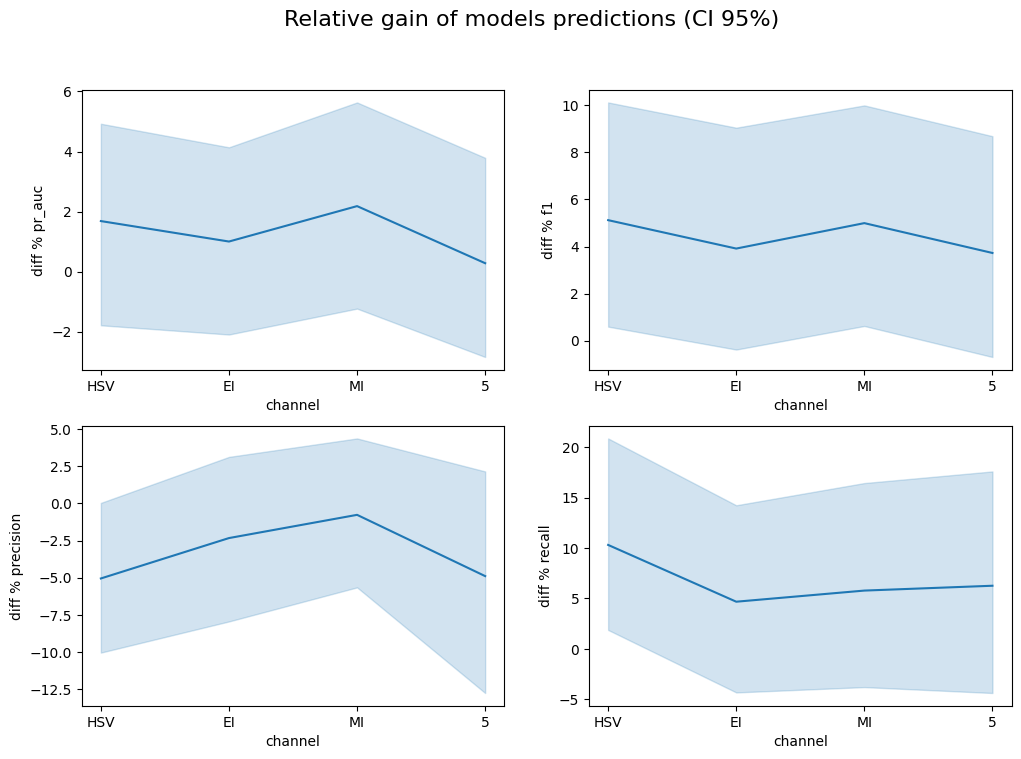

In [199]:
# for metr in diff_metrics_cols:
#     sns.lineplot(data = df_diff_metrics_100, x = "channel", y = metr)
#     plt.show()
    
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=False, sharey=False)
fig.suptitle('Relative gain of models predictions (CI 95%)', fontsize=16)
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        mtr = diff_metrics_cols[1 + i * 2 + j]
        sns.lineplot(data = df_diff_metrics_100, x = "channel", y = mtr, ax = axs[i, j])
#         sns.boxplot(df_diff_metrics_100, x = 'channel', y = mtr, ax = axs[i, j])
plt.plot()    

[]

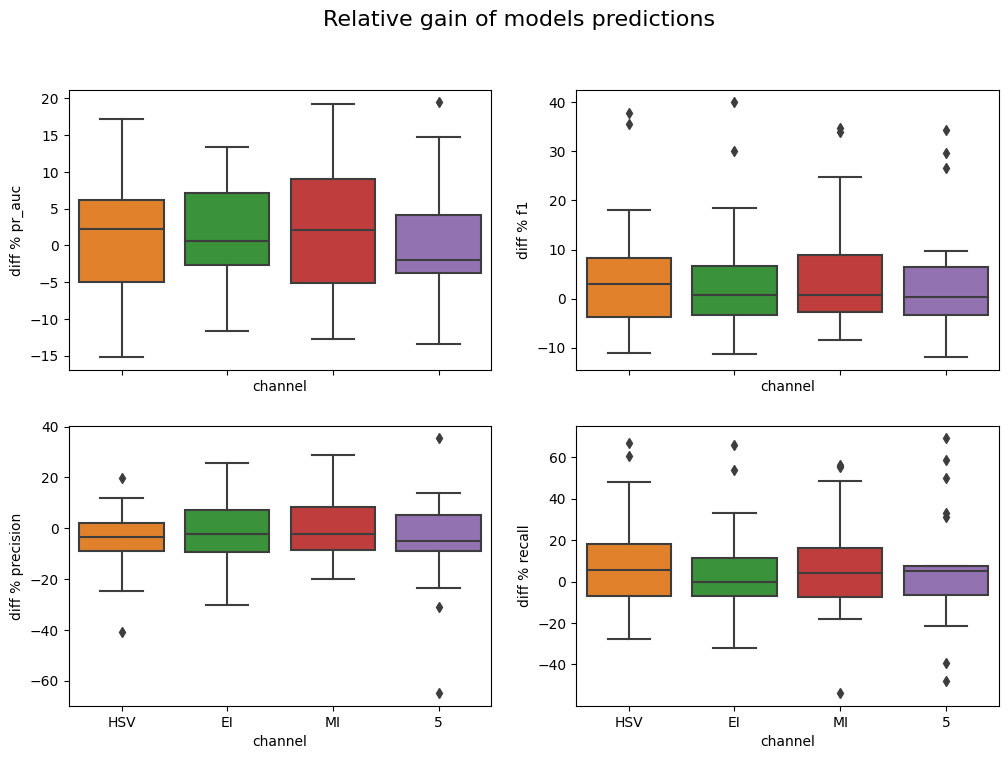

In [201]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=False)
fig.suptitle('Relative gain of models predictions', fontsize=16)
for i in range(2):
    for j in range(2):
        mtr = diff_metrics_cols[1 + i * 2 + j]
        sns.boxplot(df_diff_metrics_100, x = 'channel', y = mtr, ax = axs[i, j])
plt.plot()

In [58]:
df_mean_metrics = pd.read_csv(f'{data_path}/{mean_metrics}')
df_mean_metrics.shape

(65, 13)

In [59]:
df_mean_metrics_VA = pd.read_csv(f'{data_path}/{mean_metrics_VA}')
df_mean_metrics_VA.dropna(inplace = True)
df_mean_metrics_VA.shape

(50, 13)

In [60]:
df_mean_metrics.tail(10)

,date,model,image_size,batch_size,channel,test_set,roc_auc,pr_auc,f1,precision,recall,uuid,drop_luminance
55,20231212,v2b2,512,32,RGB,test_loc,0.769285,0.301674,0.295727,0.337719,0.263023,bd3ebf41-93a4-47e1-8e0e-3469143ff3dd,False
56,20231212,v2b2,512,32,3,test_loc,0.782410,0.324289,0.360536,0.280170,0.505551,bd3ebf41-93a4-47e1-8e0e-3469143ff3dd,False
57,20231212,v2b2,512,32,EI,test_loc,0.792293,0.335841,0.362919,0.337243,0.392827,bd3ebf41-93a4-47e1-8e0e-3469143ff3dd,False
58,20231212,v2b2,512,32,MI,test_loc,0.801955,0.373706,0.393561,0.319808,0.511529,bd3ebf41-93a4-47e1-8e0e-3469143ff3dd,False
59,20231212,v2b2,512,32,5,test_loc,0.805008,0.374467,0.402746,0.326271,0.526046,bd3ebf41-93a4-47e1-8e0e-3469143ff3dd,False
60,20240118,v2b2,256,32,RGB,test_loc,0.823948,0.411826,0.418047,0.355942,0.506405,4369325a-92e5-40b7-9804-24a79f5d1e61,True
61,20240118,v2b2,256,32,3,test_loc,0.821457,0.422726,0.429426,0.365269,0.520922,4369325a-92e5-40b7-9804-24a79f5d1e61,True
62,20240118,v2b2,256,32,EI,test_loc,0.805168,0.401328,0.411969,0.347622,0.505551,4369325a-92e5-40b7-9804-24a79f5d1e61,True
63,20240118,v2b2,256,32,MI,test_loc,0.810246,0.384401,0.404928,0.331878,0.519214,4369325a-92e5-40b7-9804-24a79f5d1e61,True
64,20240118,v2b2,256,32,5,test_loc,0.816063,0.395920,0.406164,0.339051,0.506405,4369325a-92e5-40b7-9804-24a79f5d1e61,True


In [61]:
df_mean_metrics_VA.tail(10)

,date,model,image_size,batch_size,channel,test_set,roc_auc,pr_auc,f1,precision,recall,uuid,drop_luminance
40,20231208,v2b1,256,32,RGB,test_loc,0.780199,0.331558,0.354306,0.371028,0.339026,32f07d38-1cb9-4058-a6a1-172e31f6df0f,False
41,20231208,v2b1,256,32,3,test_loc,0.788649,0.338169,0.370112,0.338527,0.408198,32f07d38-1cb9-4058-a6a1-172e31f6df0f,False
42,20231208,v2b1,256,32,EI,test_loc,0.790500,0.335523,0.356420,0.338983,0.375747,32f07d38-1cb9-4058-a6a1-172e31f6df0f,False
43,20231208,v2b1,256,32,MI,test_loc,0.790032,0.338453,0.374388,0.317131,0.456874,32f07d38-1cb9-4058-a6a1-172e31f6df0f,False
44,20231208,v2b1,256,32,5,test_loc,0.782694,0.322522,0.354019,0.345528,0.362938,32f07d38-1cb9-4058-a6a1-172e31f6df0f,False
45,20231223,vgg16,256,64,RGB,test_loc,0.825661,0.414409,0.427486,0.339708,0.576430,6d1b6c7b-fefa-4922-ac1b-0c99320743aa,False
46,20231223,vgg16,256,64,3,test_loc,0.825061,0.413878,0.407560,0.300000,0.635354,6d1b6c7b-fefa-4922-ac1b-0c99320743aa,False
47,20231223,vgg16,256,64,EI,test_loc,0.822164,0.404381,0.411893,0.302605,0.644748,6d1b6c7b-fefa-4922-ac1b-0c99320743aa,False
48,20231223,vgg16,256,64,MI,test_loc,0.822389,0.411792,0.421601,0.340515,0.553373,6d1b6c7b-fefa-4922-ac1b-0c99320743aa,False
49,20231223,vgg16,256,64,5,test_loc,0.822423,0.399359,0.413754,0.311341,0.616567,6d1b6c7b-fefa-4922-ac1b-0c99320743aa,False


In [62]:
# uuid_left = set(df_mean_metrics.uuid)
# uuid_right = set(df_mean_metrics_VA.uuid)
# uuid_add = uuid_right - uuid_left
# # print(uuid_add)

# df_mean_metrics_all = pd.concat([df_mean_metrics, df_mean_metrics_VA.loc[df_mean_metrics_VA.uuid.isin(uuid_add)]], axis = 0).reindex()
# print(df_mean_metrics_all.shape[0])

df_mean_metrics_all = pd.concat([df_mean_metrics, df_mean_metrics_VA], axis = 0).reindex()
print(df_mean_metrics_all.shape)

(115, 13)


In [63]:
df_mean_metrics_all.loc[df_mean_metrics_all.channel == '3', 'channel'] = 'HSV'
df_mean_metrics_all

,date,model,image_size,batch_size,channel,test_set,roc_auc,pr_auc,f1,precision,recall,uuid,drop_luminance
0,20231206,v1b1,256,64,RGB,test_loc,0.804052,0.375983,0.397373,0.322839,0.516652,6b8da835-8e14-4efb-ba53-38222eedf65e,False
1,20231206,v1b1,256,64,HSV,test_loc,0.784139,0.352186,0.381193,0.302302,0.515798,6b8da835-8e14-4efb-ba53-38222eedf65e,False
2,20231206,v1b1,256,64,EI,test_loc,0.792218,0.353423,0.383570,0.300435,0.530316,6b8da835-8e14-4efb-ba53-38222eedf65e,False
3,20231206,v1b1,256,64,MI,test_loc,0.786360,0.350577,0.378149,0.293315,0.532024,6b8da835-8e14-4efb-ba53-38222eedf65e,False
4,20231206,v1b1,256,64,5,test_loc,0.792192,0.363164,0.388033,0.297052,0.559351,6b8da835-8e14-4efb-ba53-38222eedf65e,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,20231223,vgg16,256,64,RGB,test_loc,0.825661,0.414409,0.427486,0.339708,0.576430,6d1b6c7b-fefa-4922-ac1b-0c99320743aa,False
46,20231223,vgg16,256,64,HSV,test_loc,0.825061,0.413878,0.407560,0.300000,0.635354,6d1b6c7b-fefa-4922-ac1b-0c99320743aa,False
47,20231223,vgg16,256,64,EI,test_loc,0.822164,0.404381,0.411893,0.302605,0.644748,6d1b6c7b-fefa-4922-ac1b-0c99320743aa,False
48,20231223,vgg16,256,64,MI,test_loc,0.822389,0.411792,0.421601,0.340515,0.553373,6d1b6c7b-fefa-4922-ac1b-0c99320743aa,False


In [85]:
df_no_luminance = df_mean_metrics_all.loc[df_mean_metrics_all.drop_luminance == True]
print(f'Number of models with omitted Luminance channel: {df_no_luminance.shape[0] / 5 : .0f}')
df_with_luminance = df_mean_metrics_all.loc[df_mean_metrics_all.drop_luminance == False]
print(f'Number of models with Luminance channel present: {df_with_luminance.shape[0] / 5:0.0f}')

Number of models with omitted Luminance channel:  4
Number of models with Luminance channel present: 19


In [87]:
(df_no_luminance.model.value_counts()/5).astype(int)

v2b0    2
v2b1    1
v2b2    1
Name: model, dtype: int32

In [88]:
(df_with_luminance.model.value_counts()/5).astype(int)

v2b0           4
v2b2           4
v2b1           2
resnet50v2     2
v1b2           2
v1b1           1
resnet101v2    1
v1b0           1
v1b5           1
vgg16          1
Name: model, dtype: int32

In [65]:
df_no_luminance.head(5)

,date,model,image_size,batch_size,channel,test_set,roc_auc,pr_auc,f1,precision,recall,uuid,drop_luminance
20,20240105,v2b0,256,64,RGB,test_loc,0.826787,0.417617,0.421935,0.356974,0.515798,6b8da835-8e14-4efb-ba53-38222eedf65e,True
21,20240105,v2b0,256,64,HSV,test_loc,0.826538,0.416977,0.447240,0.378474,0.546541,6b8da835-8e14-4efb-ba53-38222eedf65e,True
22,20240105,v2b0,256,64,EI,test_loc,0.819345,0.417683,0.430643,0.381423,0.494449,6b8da835-8e14-4efb-ba53-38222eedf65e,True
23,20240105,v2b0,256,64,MI,test_loc,0.826759,0.413604,0.425376,0.349232,0.543980,6b8da835-8e14-4efb-ba53-38222eedf65e,True
24,20240105,v2b0,256,64,5,test_loc,0.824477,0.404309,0.419489,0.352293,0.518360,6b8da835-8e14-4efb-ba53-38222eedf65e,True


In [102]:
df_effnetv2 = df_mean_metrics_all.loc[df_mean_metrics_all.model.isin(['v2b0', 'v2b1', 'v2b2'])]

In [103]:
df_mean_metrics_all['effnetv2'] = df_mean_metrics_all.model.isin(['v2b0', 'v2b1', 'v2b2'])
# df_mean_metrics_all

In [42]:
def plot_metrics(df_mean_metrics):
    df_mean = df_mean_metrics.groupby(['test_set','channel'])['roc_auc'].mean()
    df_mean_all = df_mean_metrics.groupby(['test_set','channel'])[metrics_cols].mean()

    for mi, mn in enumerate(metrics_cols):  
        fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)
        for ti, tn in enumerate(test_label):
            metrics_dict = dict(df_mean_all.loc[test_label[ti]][mn])
            rearr = {}
            for ch in channel_label:
                rearr[ch] = metrics_dict[ch]
            x = list(rearr.keys())
            y = list(rearr.values())
            max_x = np.argmax(y)
            max_y = np.array(y).max()
            ax.plot(max_x, max_y, marker = 'o')
            ax.plot(x, y,
                    color = colors[color_index[ti]],
                    label = f"{mn} for {tn}",
                    lw=2,
                    alpha = 0.9)   
        ax.set(xlabel = "Channels",
                ylabel = mn,
                title = f"Mean {mn} for all channels")   
        ax.legend(loc="lower right")
        plt.show()

In [43]:
def print_metrics_CI(df_mean_metrics_all):
    for ti, tn in enumerate(test_label):
        n_samples = df_mean_metrics_all.loc[(df_mean_metrics_all.test_set == tn)].shape[0]
        print(f'\nTest set - {tn}, {test_classes[tn][0]} bening and {test_classes[tn][1]} malignant samples')
        print(f'{n_samples//5} models results:')
        for mi, metr in enumerate(metrics_cols):
            print(f"{metric_name[mi]}")
            table = []
            m_values = np.zeros(5)
            for ci, ch in enumerate(channel_label):
                df_temp = df_mean_metrics_all.loc[(df_mean_metrics_all.test_set == tn) & (df_mean_metrics_all.channel == ch)]
                ci_metr = st.t.interval(0.95, df = (df_temp.shape[0])-1, loc=np.mean(df_temp[metr].values), scale=st.sem(df_temp[metr].values)) 
                table = table + [[channel_label_alt[ci], f'{np.mean(df_temp[metr].values) * 100:.2f}%', f'({ci_metr[0] * 100:.2f}%, {ci_metr[1] * 100:.2f}%)']]
                m_values[ci] = np.mean(df_temp[metr].values) * 100
            max_i = np.argmax(m_values)
            table[max_i][1] = '-> ' + table[max_i][1] + ' <-'
            print(tabulate(table, ['Channels', 'Mean','95% Confidence interval'], tablefmt="rounded_outline", colalign=('left', "center", "center")))

In [66]:
print_metrics_CI(df_no_luminance)


Test set - test_loc, 9554 bening and 1171 malignant samples
4 models results:
ROC AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │    81.25%    │     (77.80%, 84.70%)      │
│ HSV           │ -> 82.08% <- │     (81.37%, 82.79%)      │
│ HSV + EI      │    80.95%    │     (79.72%, 82.18%)      │
│ HSV + MI      │    80.88%    │     (78.33%, 83.42%)      │
│ HSV + EI + MI │    81.74%    │     (80.96%, 82.51%)      │
╰───────────────┴──────────────┴───────────────────────────╯
PR AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │    39.13%    │     (33.15%, 45.11%)      │
│ HSV           │ -> 41.69% <- │     (40.43%, 42.95%)      │
│ HSV + EI      │    40.21%    │     (37.96%, 42.46%

In [67]:
print_metrics_CI(df_mean_metrics_all)


Test set - test_loc, 9554 bening and 1171 malignant samples
23 models results:
ROC AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │    79.25%    │     (78.28%, 80.23%)      │
│ HSV           │ -> 79.52% <- │     (78.79%, 80.26%)      │
│ HSV + EI      │    79.35%    │     (78.69%, 80.00%)      │
│ HSV + MI      │    79.47%    │     (78.83%, 80.10%)      │
│ HSV + EI + MI │    79.38%    │     (78.51%, 80.25%)      │
╰───────────────┴──────────────┴───────────────────────────╯
PR AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │    35.43%    │     (33.68%, 37.18%)      │
│ HSV           │    36.11%    │     (34.54%, 37.68%)      │
│ HSV + EI      │    35.79%    │     (34.44%, 37.15

In [95]:
print_metrics_CI(df_effnetv2)


Test set - test_loc, 9554 bening and 1171 malignant samples
14 models results:
ROC AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │    78.38%    │     (76.98%, 79.79%)      │
│ HSV           │ -> 79.60% <- │     (78.52%, 80.69%)      │
│ HSV + EI      │    79.39%    │     (78.47%, 80.31%)      │
│ HSV + MI      │    79.60%    │     (78.73%, 80.47%)      │
│ HSV + EI + MI │    79.27%    │     (77.92%, 80.63%)      │
╰───────────────┴──────────────┴───────────────────────────╯
PR AUC
╭───────────────┬──────────────┬───────────────────────────╮
│ Channels      │     Mean     │  95% Confidence interval  │
├───────────────┼──────────────┼───────────────────────────┤
│ RGB           │    33.85%    │     (31.36%, 36.34%)      │
│ HSV           │    35.88%    │     (33.48%, 38.28%)      │
│ HSV + EI      │    35.70%    │     (33.63%, 37.76

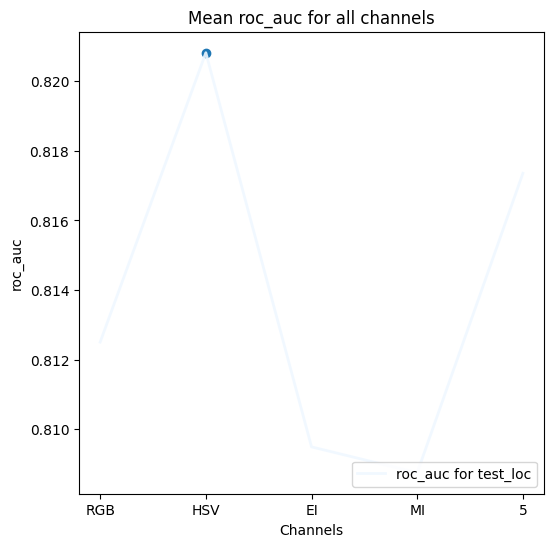

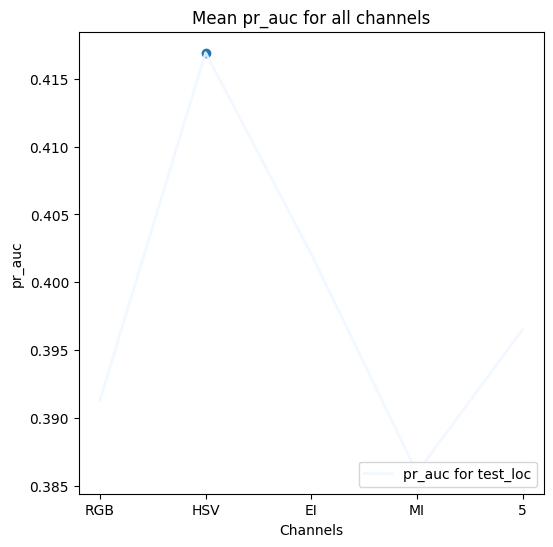

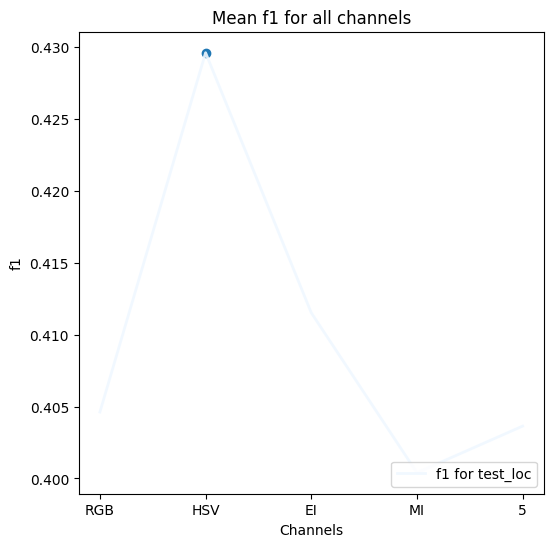

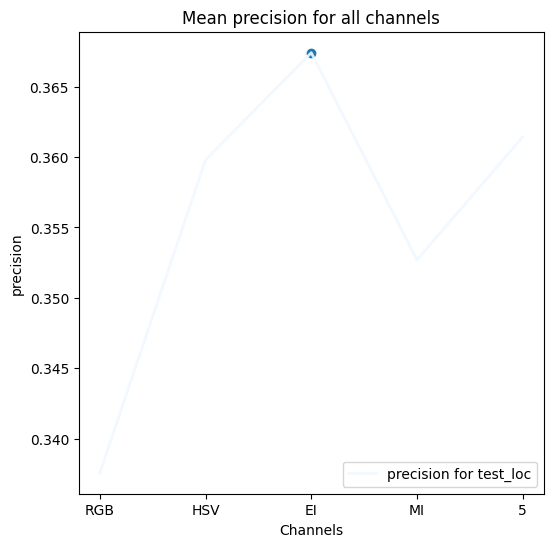

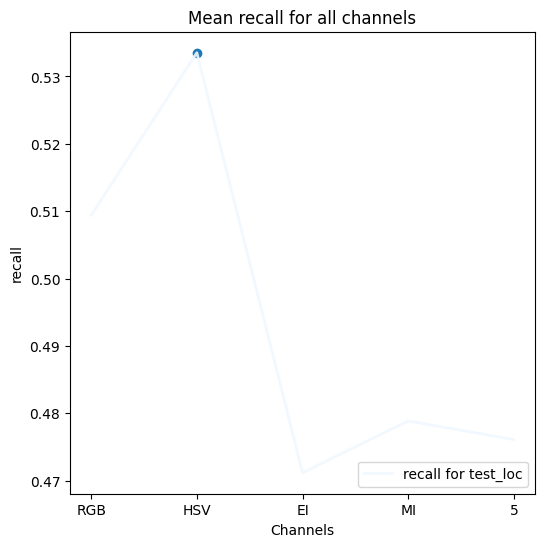

In [68]:
plot_metrics(df_no_luminance)

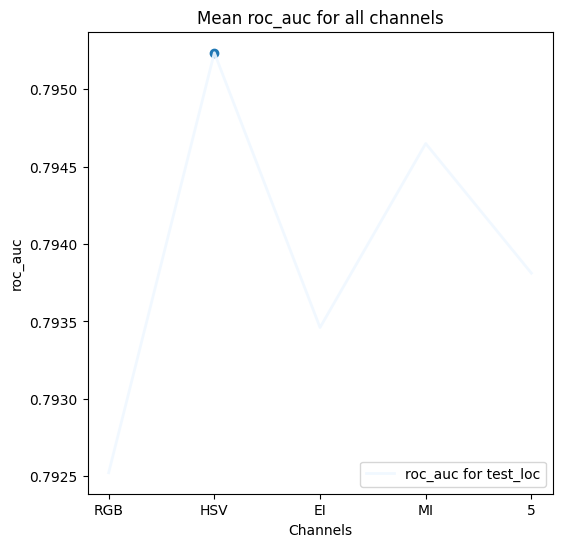

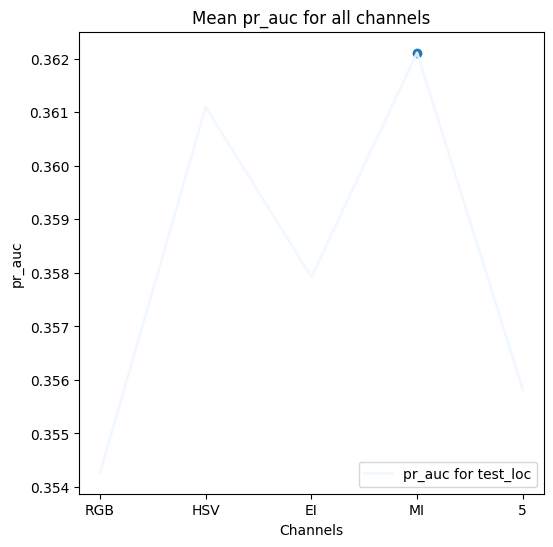

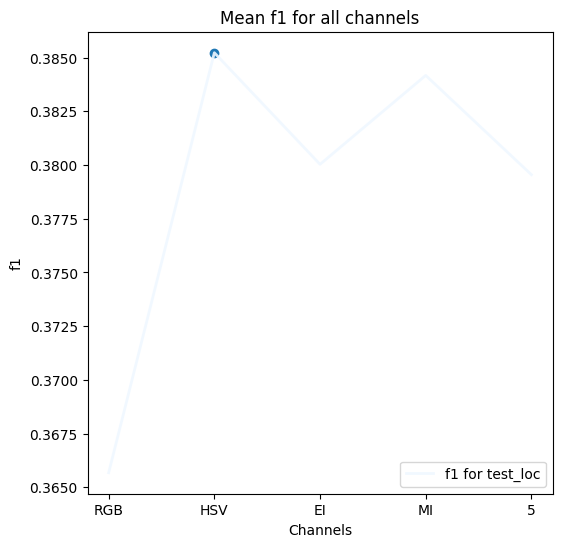

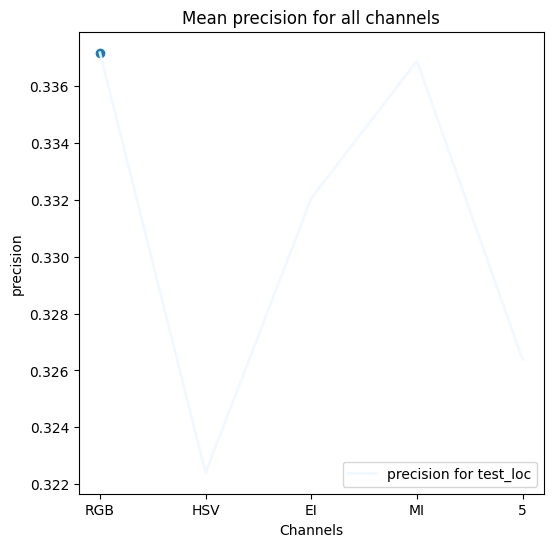

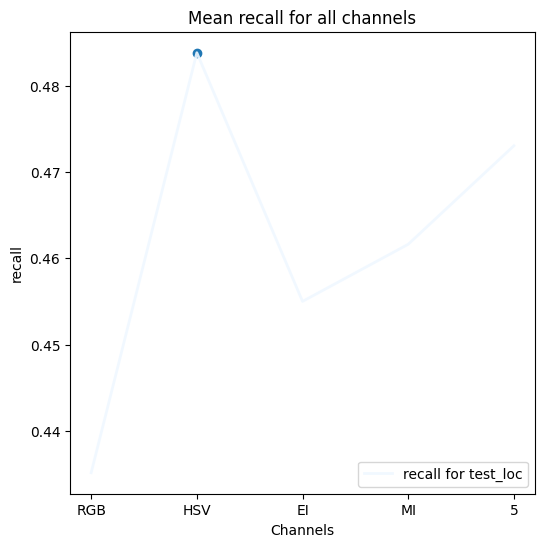

In [69]:
plot_metrics(df_mean_metrics_all)

[]

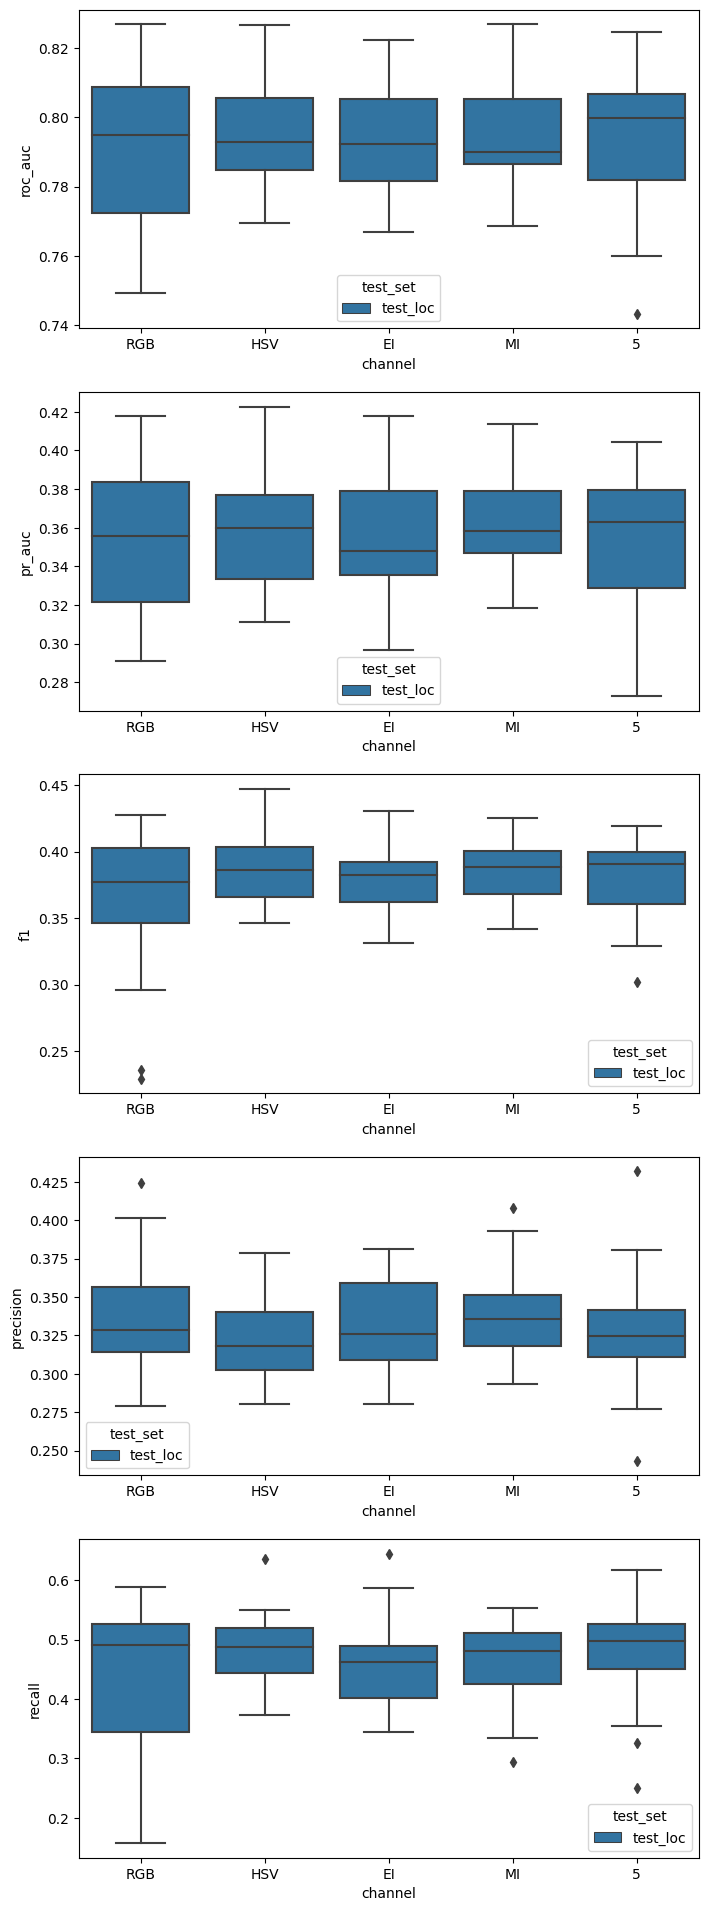

In [70]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 24))
for i, mtr in enumerate(metrics_cols):
    sns.boxplot(df_mean_metrics_all, x = 'channel', y = mtr, hue = 'test_set', ax = axs[i])

plt.plot()

[]

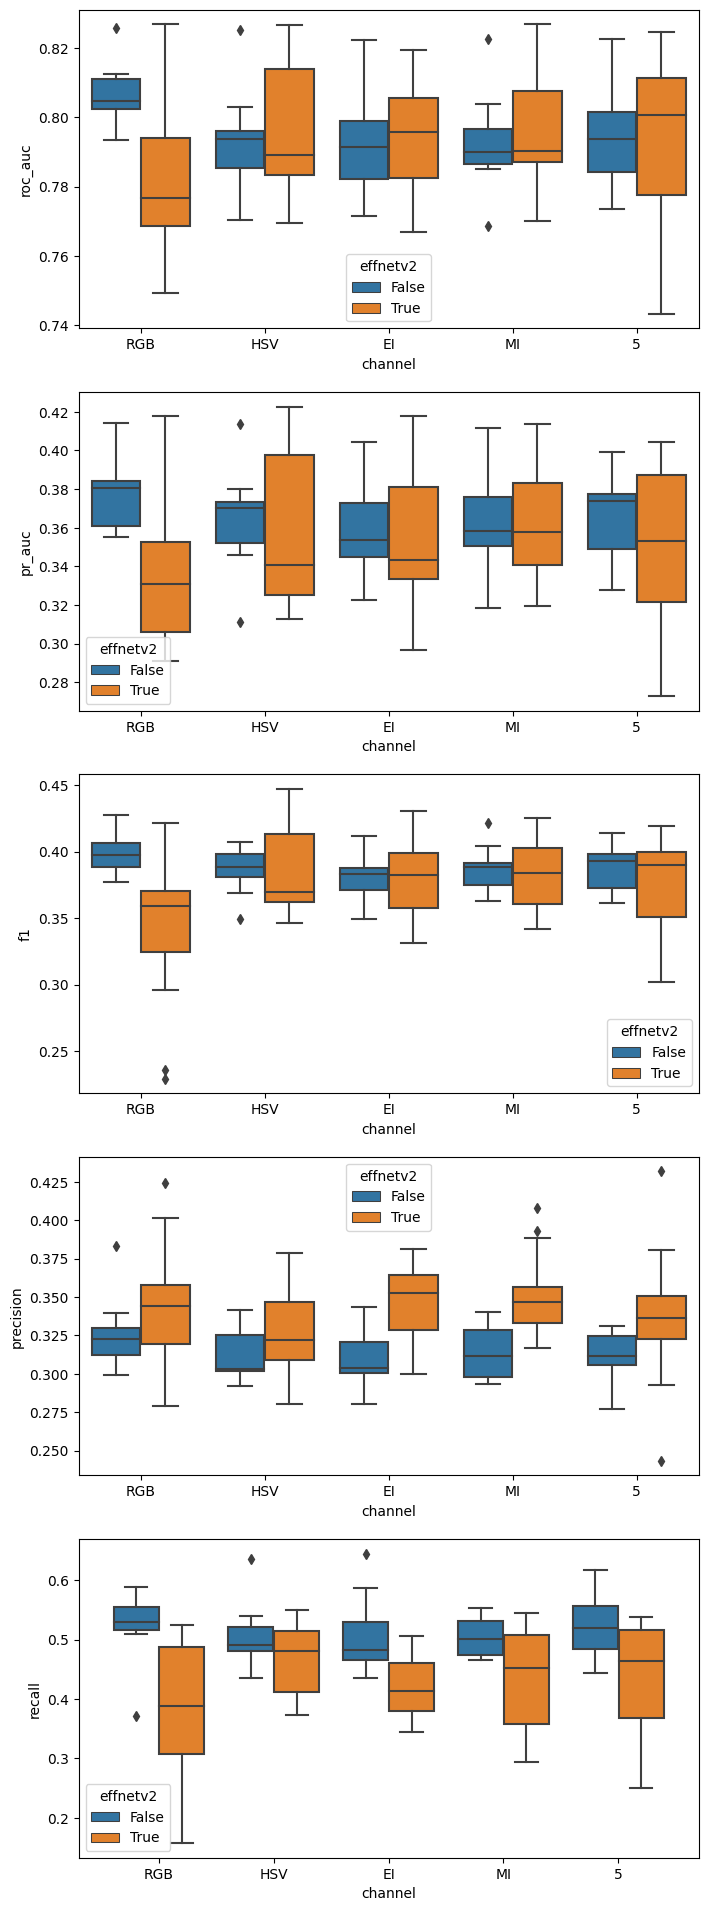

In [104]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 24))
for i, mtr in enumerate(metrics_cols):
    sns.boxplot(df_mean_metrics_all, x = 'channel', y = mtr, hue = 'effnetv2', ax = axs[i])

plt.plot()

[]

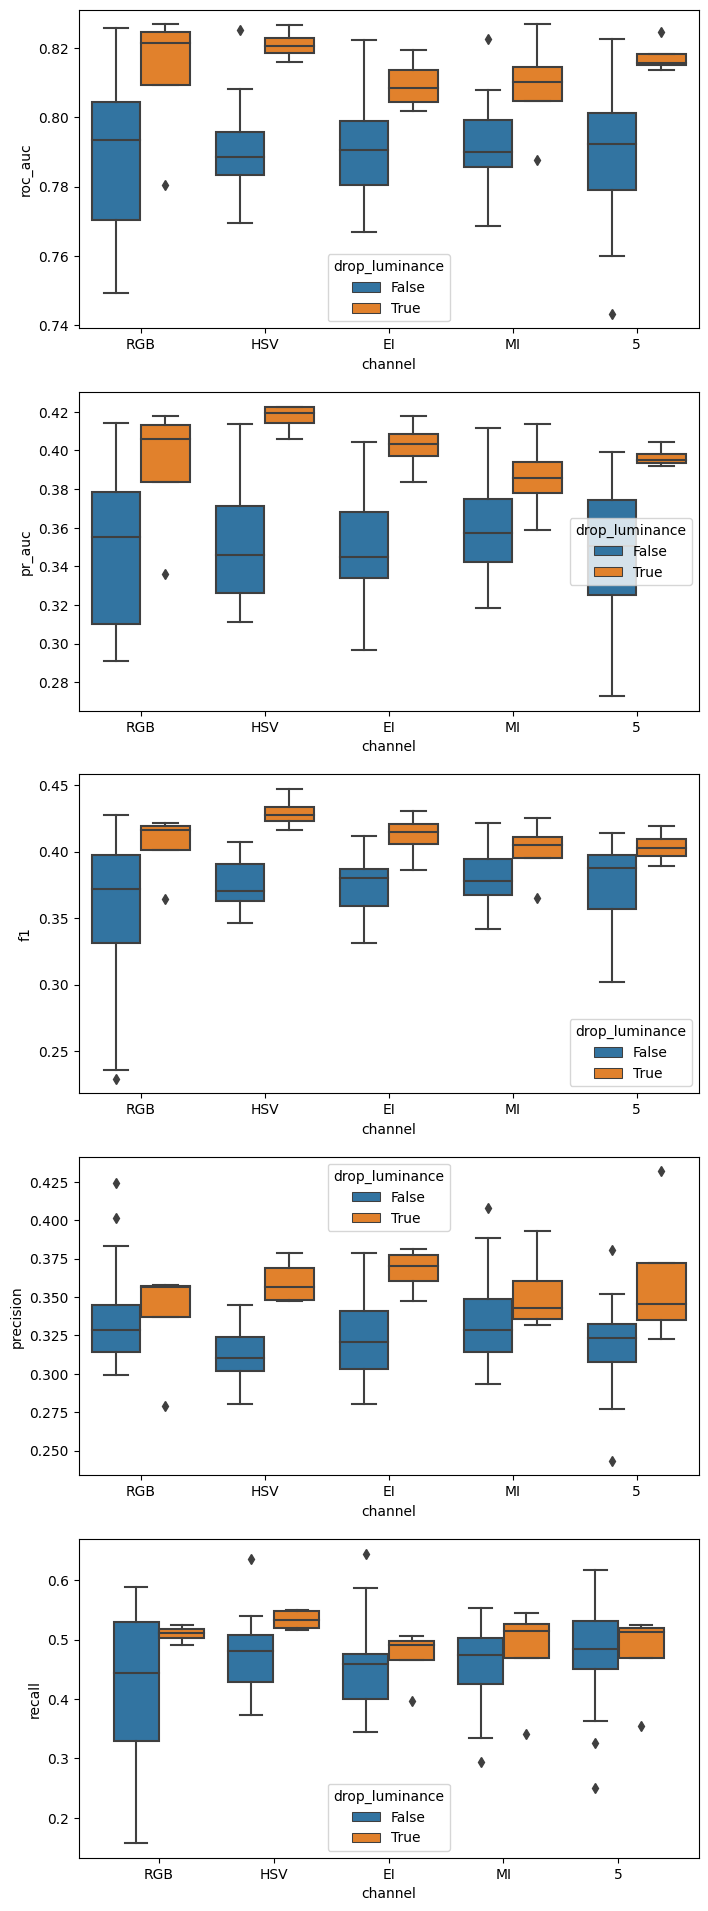

In [71]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 24))
for i, mtr in enumerate(metrics_cols):
    sns.boxplot(df_mean_metrics_all, x = 'channel', y = mtr, hue = 'drop_luminance', ax = axs[i])

plt.plot()


[]

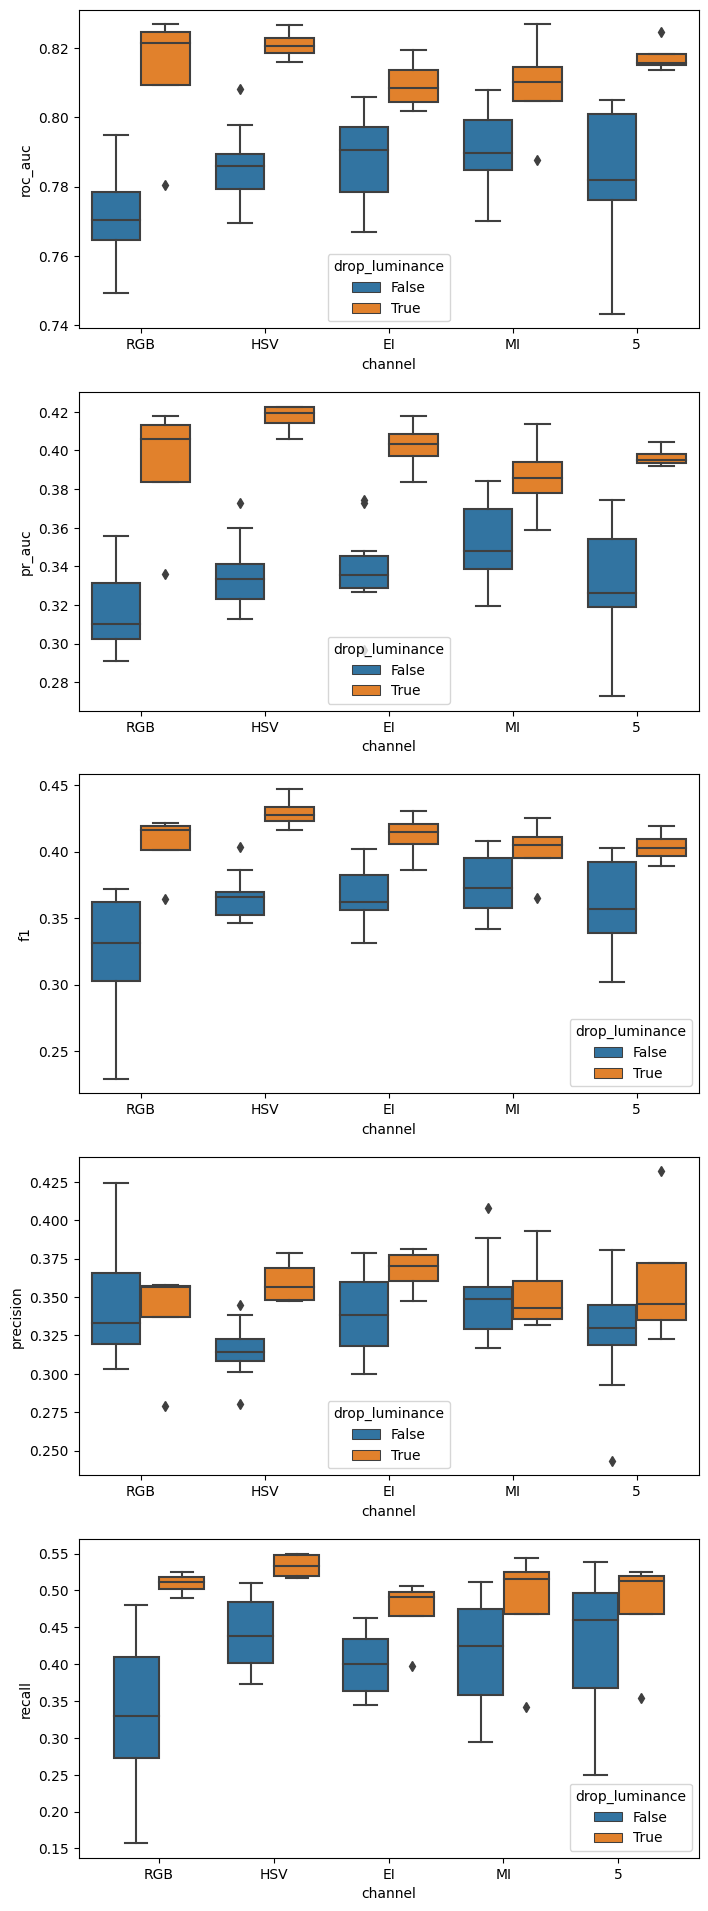

In [96]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 24))
for i, mtr in enumerate(metrics_cols):
    sns.boxplot(df_effnetv2, x = 'channel', y = mtr, hue = 'drop_luminance', ax = axs[i])

plt.plot()

[]

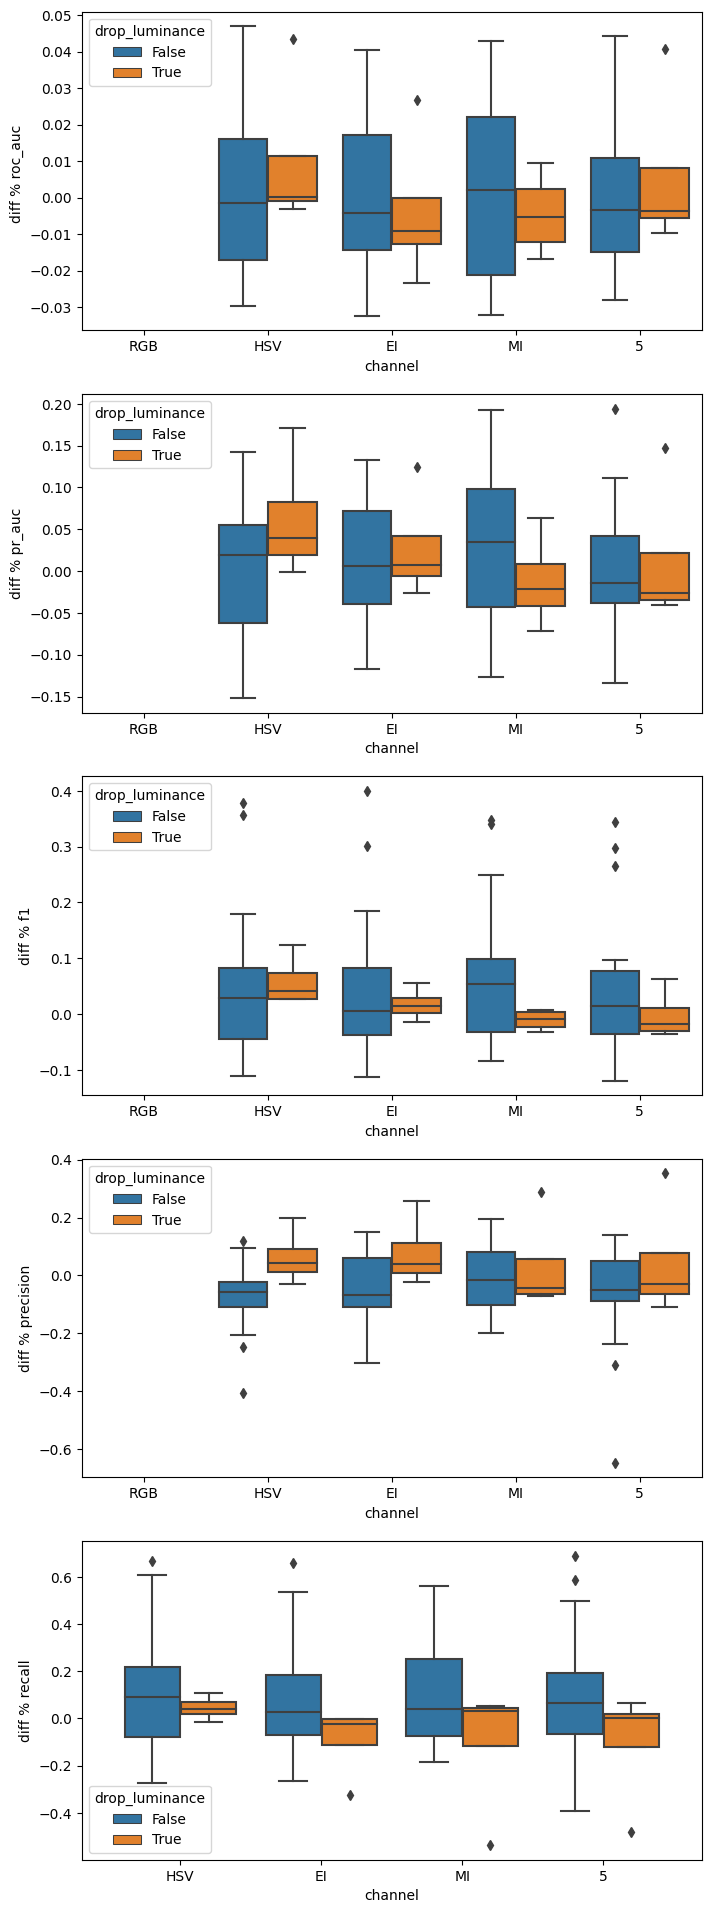

In [109]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8, 24))
for i, mtr in enumerate(diff_metrics_cols):
    sns.boxplot(df_diff_metrics, x = 'channel', y = mtr, hue = 'drop_luminance', ax = axs[i])

plt.plot()

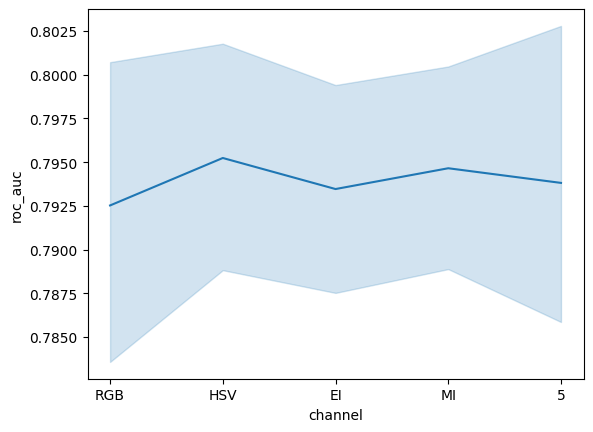

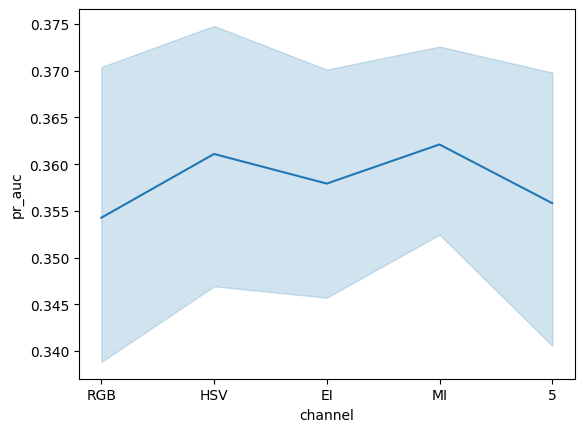

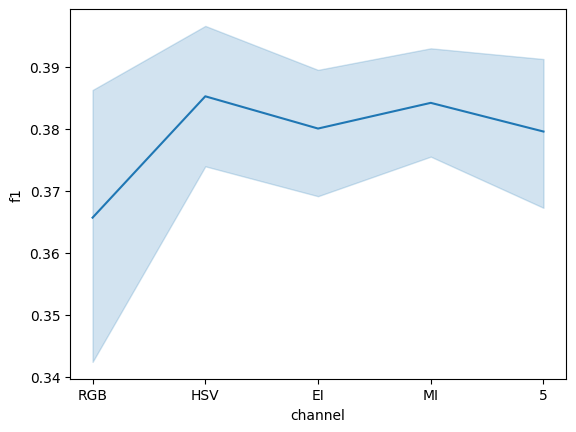

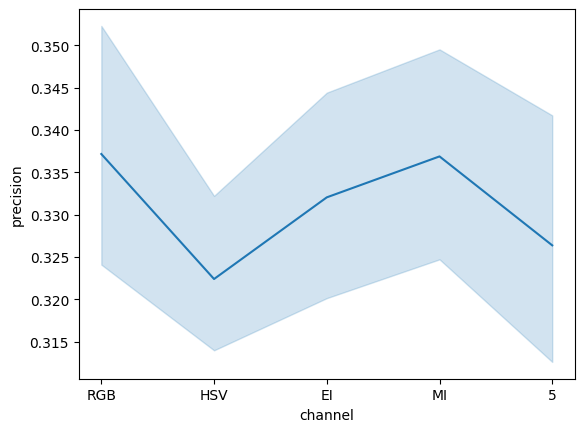

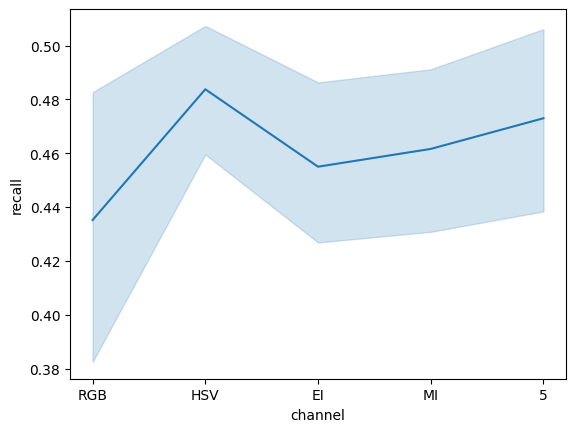

In [72]:
for metr in metrics_cols:
    sns.lineplot(data = df_mean_metrics_all.loc[df_mean_metrics_all.test_set == 'test_loc'], x = "channel", y = metr)
    plt.show()

In [73]:
def plot(models_res, ch1 = 'RGB', ch2 = 'HSV', test_set = 'test_loc'):
    print('Null hypothesis is that the means are indistinguishable. \n')
    df_metrics = models_res.loc[models_res.test_set == test_set]
    CV_ch1 = df_metrics.loc[df_metrics.channel == ch1]
    CV_ch2 = df_metrics.loc[df_metrics.channel == ch2]
    
    labels_all = [ch1, ch2]
    alpha = 0.05
    n_bins = 25
    
    print(f"Number of the data points for test set dataset: {CV_ch1.shape[0]}")
    
    n_points = CV_ch1.shape[0]
                                   
    # degrees of freedom
    df = n_points * 2 - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
    
    for n_metric in range(len(metrics_cols)):
#         n_metric = 1
        c_metric = metrics_cols[n_metric]

        CV_ch1_mean = CV_ch1[c_metric].mean()
        CV_ch2_mean = CV_ch2[c_metric].mean()
        CV_ch1_min = CV_ch1[c_metric].min()
        CV_ch2_min = CV_ch2[c_metric].min()

        colors = ['olive', 'skyblue']

        x = np.array([CV_ch1[c_metric].values, CV_ch2[c_metric].values]).T
        fig, ax1 = plt.subplots(layout='constrained', figsize=(8, 6))
        density_1 = st.gaussian_kde(CV_ch1[c_metric].values)
        density_2 = st.gaussian_kde(CV_ch2[c_metric].values)
        counts, bins, _ = ax1.hist(x, n_bins, density = False, histtype ='bar', color = colors, label = labels_all, alpha = 0.7)
        ax1.tick_params(axis='y', labelcolor = 'red')
        ax1.vlines(CV_ch1_mean, 0, counts.max() + 0.5, colors = ['greenyellow'])
        ax1.vlines(CV_ch2_mean, 0, counts.max() + 0.5, colors = ['steelblue'])
        ax1.text(0.05, 0.9, f'{c_metric} for {ch1} channels mean = {CV_ch1_mean:.4f}', transform=ax1.transAxes, color = 'yellowgreen')
        ax1.text(0.05, 0.85, f'{c_metric} for {ch2} channels mean = {CV_ch2_mean:.4f}', transform=ax1.transAxes, color = 'steelblue', zorder = 2)
        ax1.legend(loc = 'upper left', ncols = 2)
        ax1.set_xlabel(c_metric)
        ax1.set_ylabel('Counts')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.plot(bins, density_1(bins), color = 'greenyellow')
        ax2.plot(bins, density_2(bins), color = 'steelblue')
        ax2.set_ylabel('Density')
        plt.title(f'Distribution of {c_metric} of {CV_ch1.shape[0]} models on {test_set} dataset - {ch1} channels vs {ch2} channels')
        plt.show()

        tstat_4, p4 = stats.ttest_ind(CV_ch1[c_metric].values, CV_ch2[c_metric].values)
        print(f"t-test for {ch2} vs {ch1} channels: t-statistic = {tstat_4:.2f}, p value = {p4:.4f}")
    #     interpret(tstat_4, p4, cv, alpha = 0.05)



Null hypothesis is that the means are indistinguishable. 

Number of the data points for test set dataset: 23
Degrees of freedom = 44, Critical Value = 1.6802 



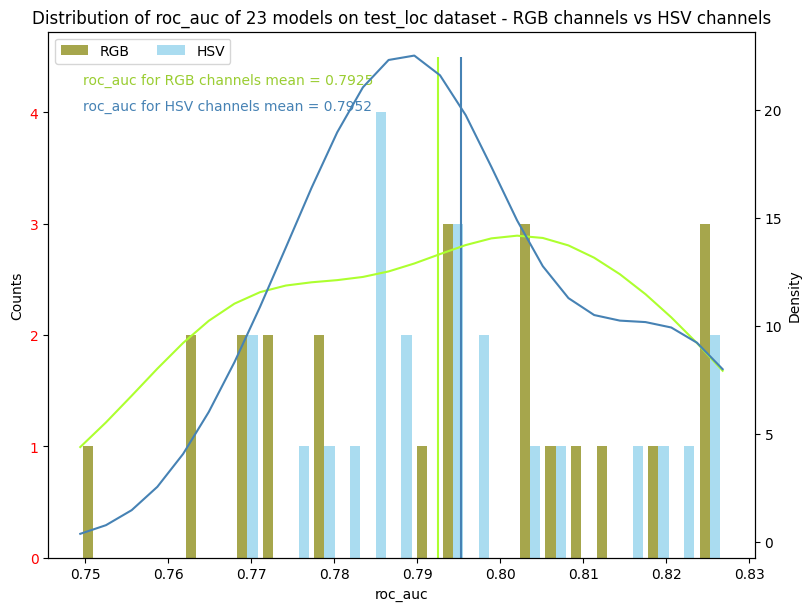

t-test for HSV vs RGB channels: t-statistic = -0.46, p value = 0.6472


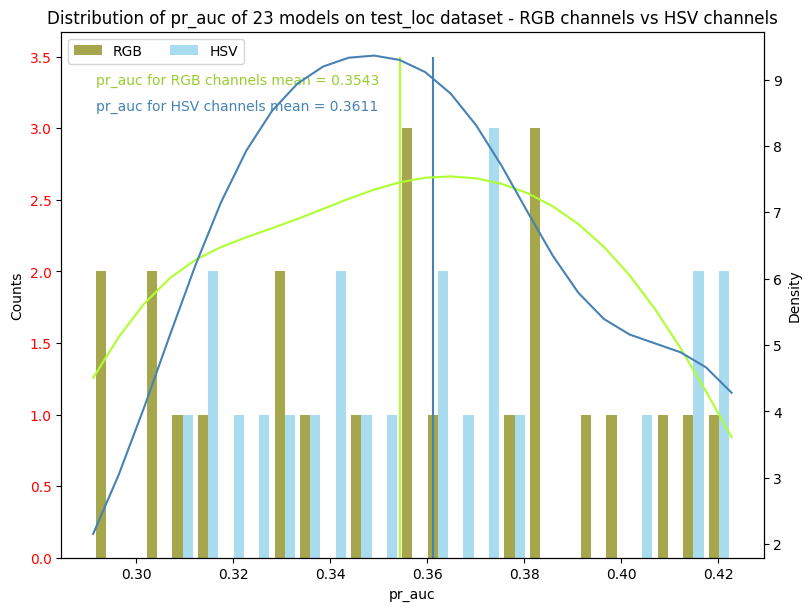

t-test for HSV vs RGB channels: t-statistic = -0.60, p value = 0.5495


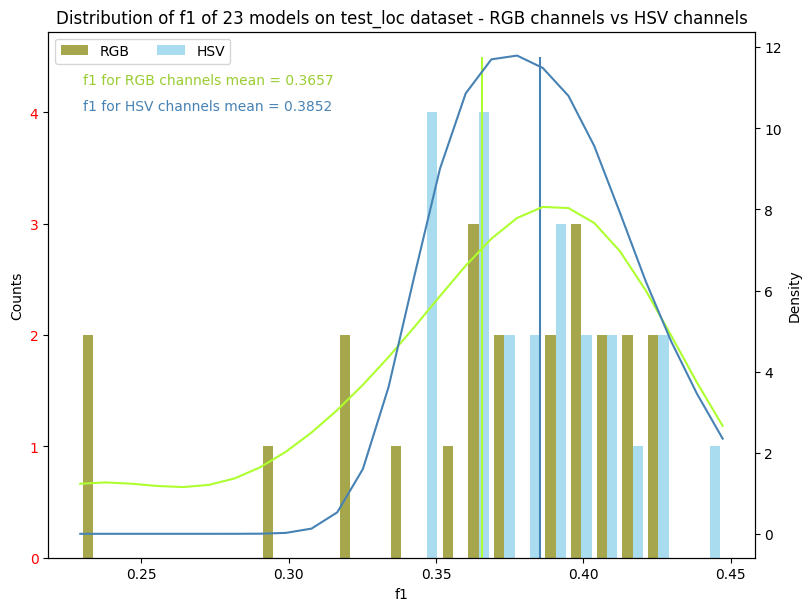

t-test for HSV vs RGB channels: t-statistic = -1.54, p value = 0.1316


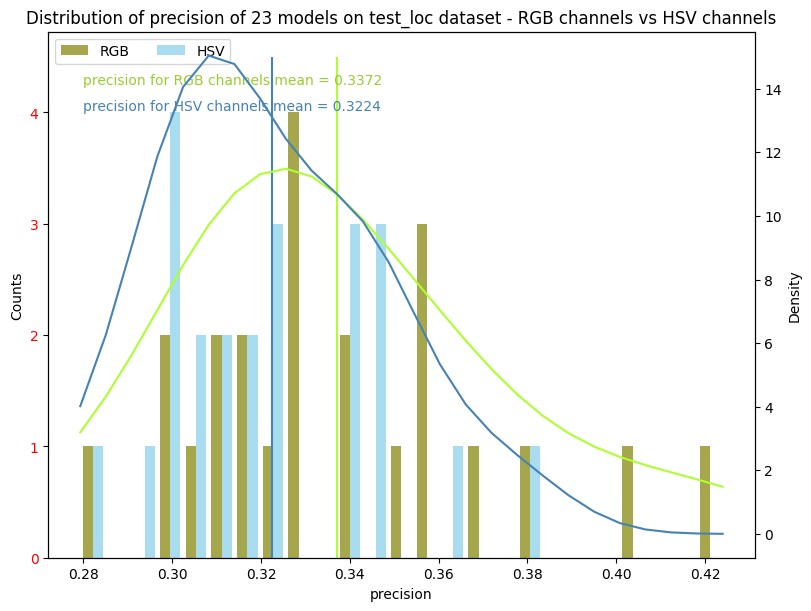

t-test for HSV vs RGB channels: t-statistic = 1.67, p value = 0.1013


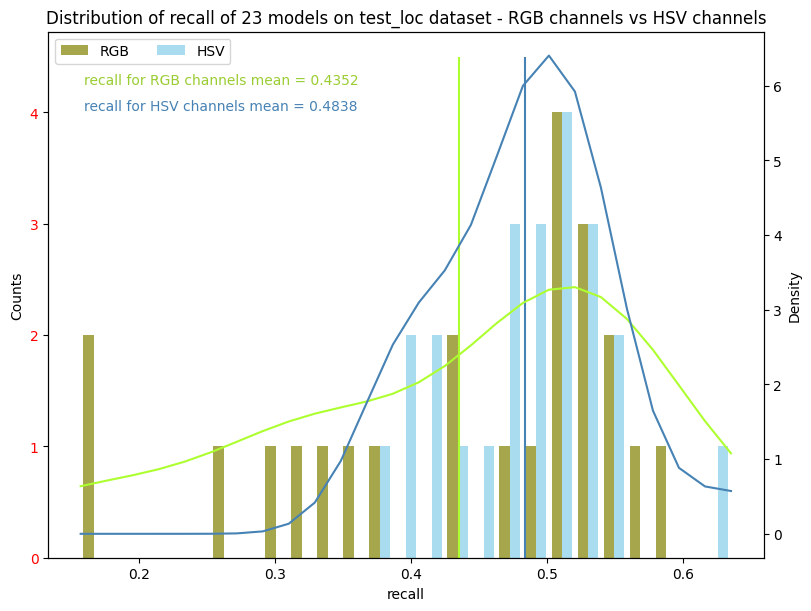

t-test for HSV vs RGB channels: t-statistic = -1.65, p value = 0.1055


In [74]:
plot(df_mean_metrics_all, ch1 = 'RGB', ch2 = 'HSV', test_set = 'test_loc')

Null hypothesis is that the means are indistinguishable. 

Number of the data points for test set dataset: 23
Degrees of freedom = 44, Critical Value = 1.6802 



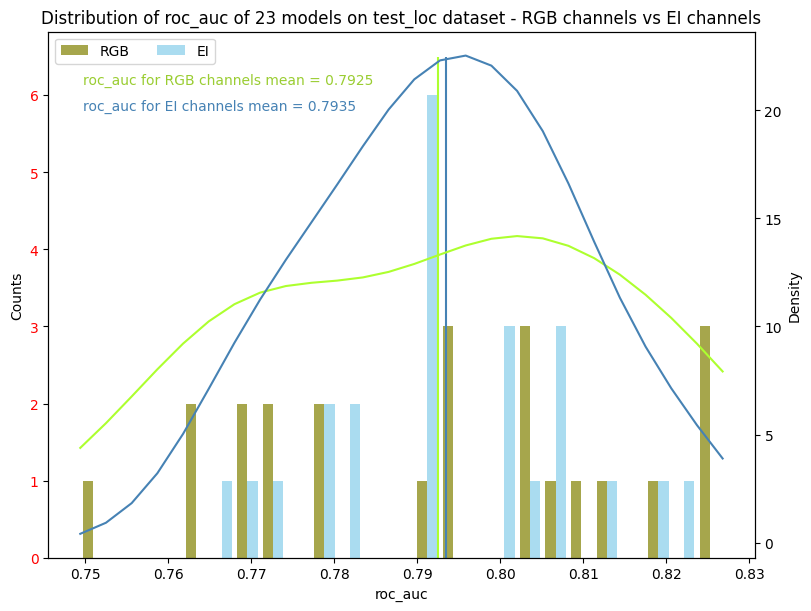

t-test for EI vs RGB channels: t-statistic = -0.17, p value = 0.8691


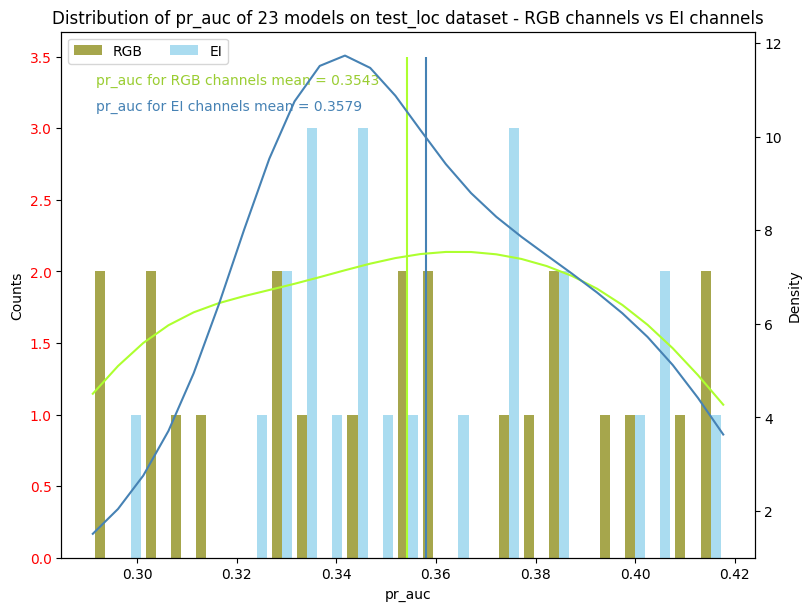

t-test for EI vs RGB channels: t-statistic = -0.34, p value = 0.7336


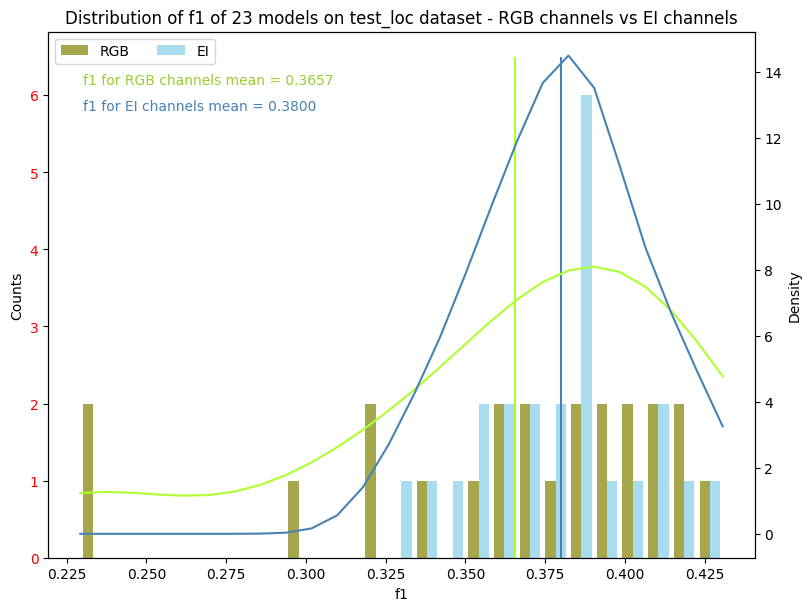

t-test for EI vs RGB channels: t-statistic = -1.15, p value = 0.2557


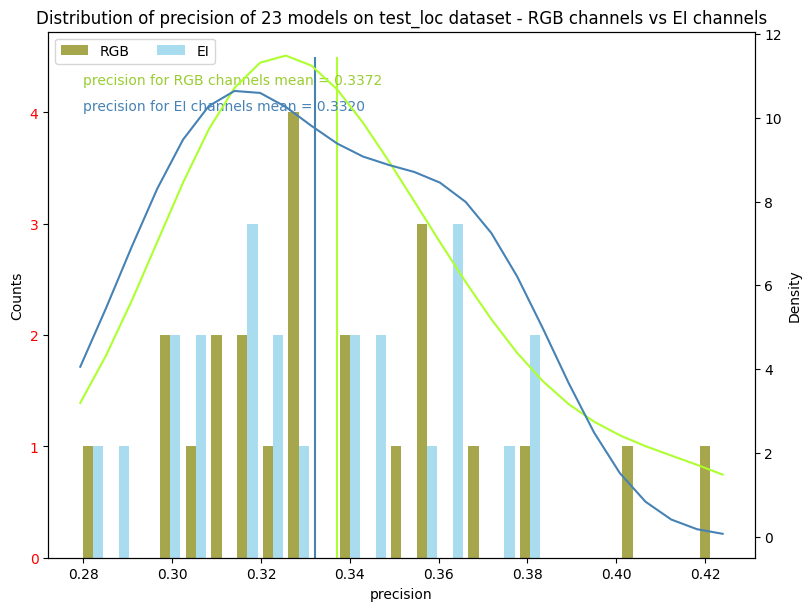

t-test for EI vs RGB channels: t-statistic = 0.54, p value = 0.5951


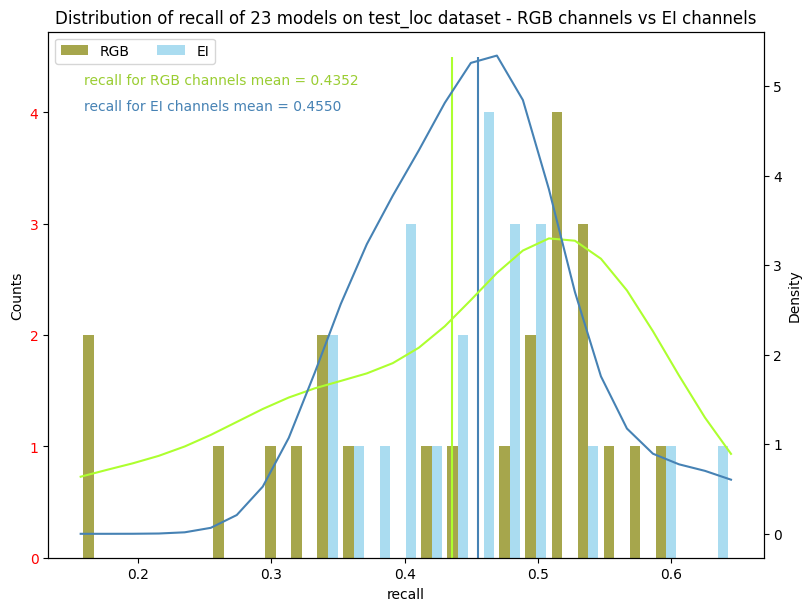

t-test for EI vs RGB channels: t-statistic = -0.65, p value = 0.5194


In [75]:
plot(df_mean_metrics_all, ch1 = 'RGB', ch2 = 'EI', test_set = 'test_loc')

Null hypothesis is that the means are indistinguishable. 

Number of the data points for test set dataset: 23
Degrees of freedom = 44, Critical Value = 1.6802 



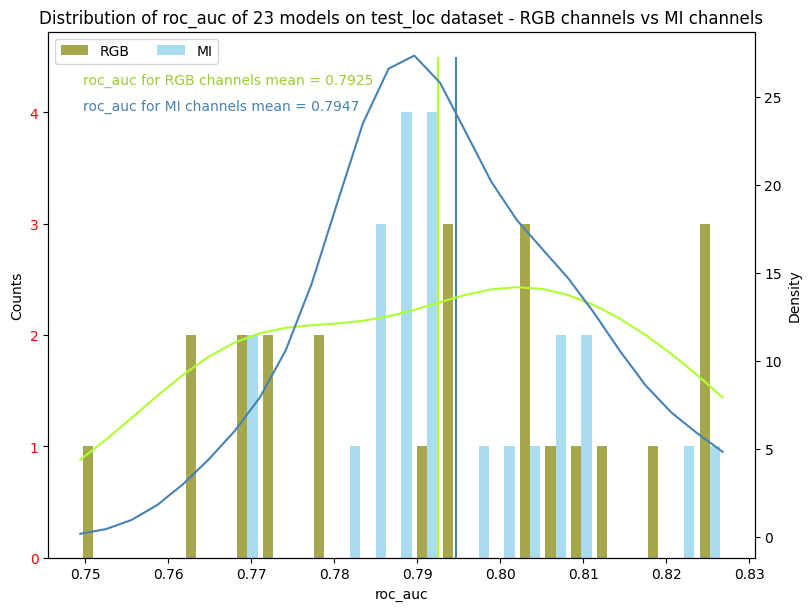

t-test for MI vs RGB channels: t-statistic = -0.38, p value = 0.7059


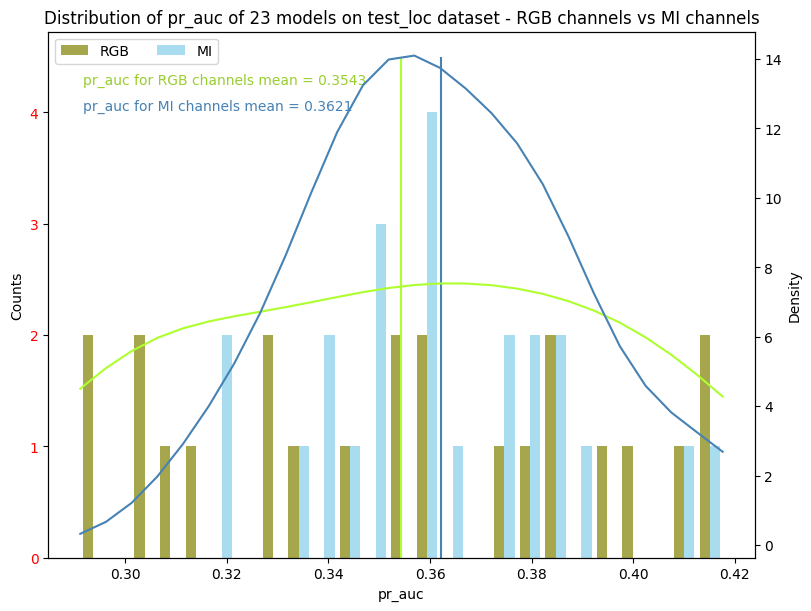

t-test for MI vs RGB channels: t-statistic = -0.79, p value = 0.4344


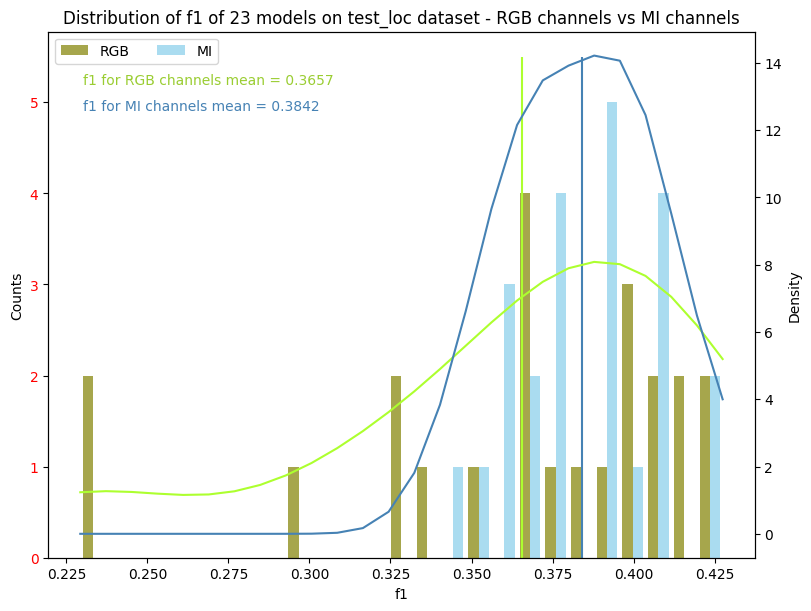

t-test for MI vs RGB channels: t-statistic = -1.51, p value = 0.1371


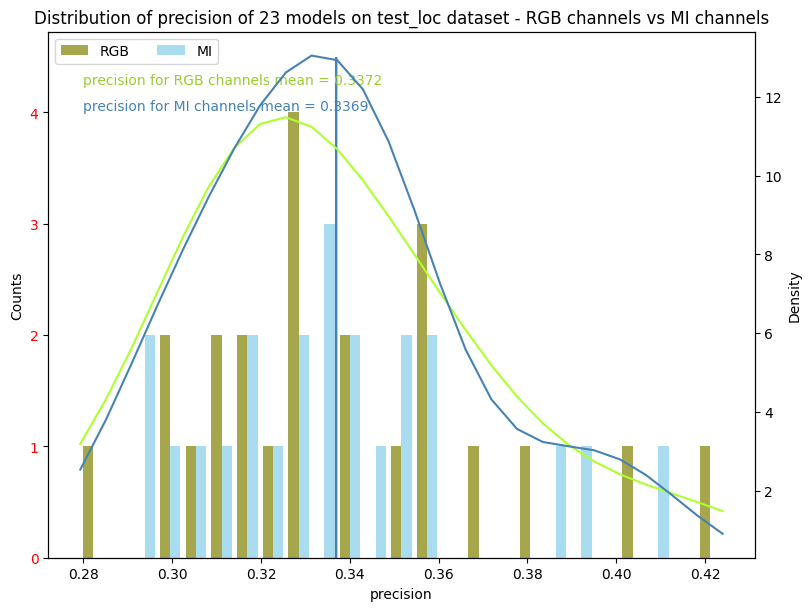

t-test for MI vs RGB channels: t-statistic = 0.03, p value = 0.9763


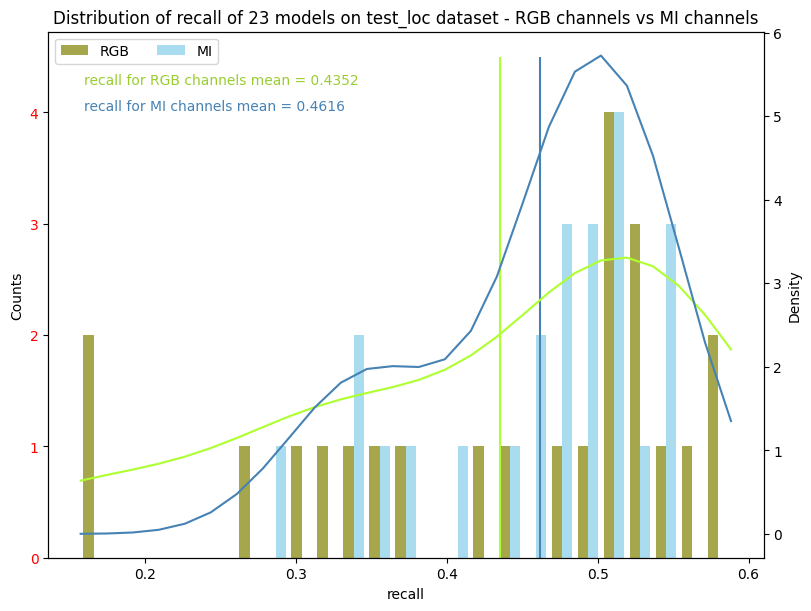

t-test for MI vs RGB channels: t-statistic = -0.86, p value = 0.3946


In [76]:
plot(df_mean_metrics_all, ch1 = 'RGB', ch2 = 'MI', test_set = 'test_loc')

Null hypothesis is that the means are indistinguishable. 

Number of the data points for test set dataset: 23
Degrees of freedom = 44, Critical Value = 1.6802 



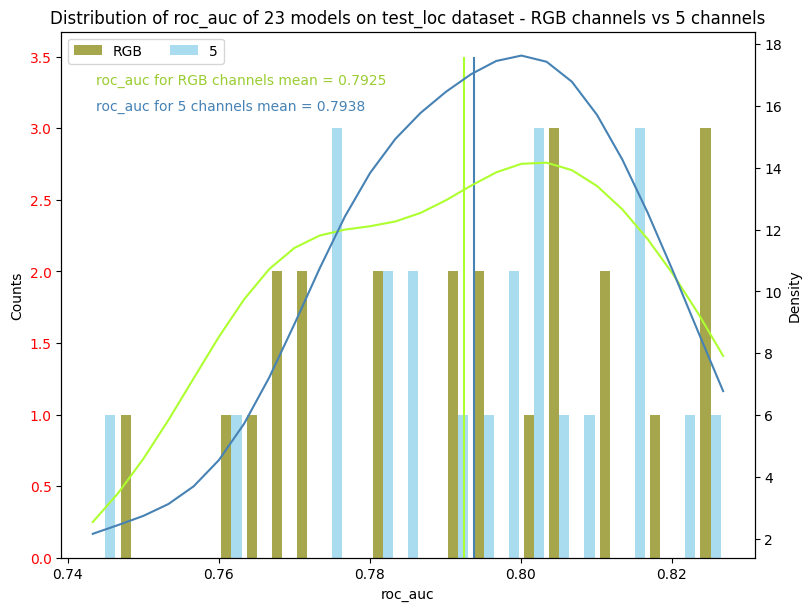

t-test for 5 vs RGB channels: t-statistic = -0.20, p value = 0.8385


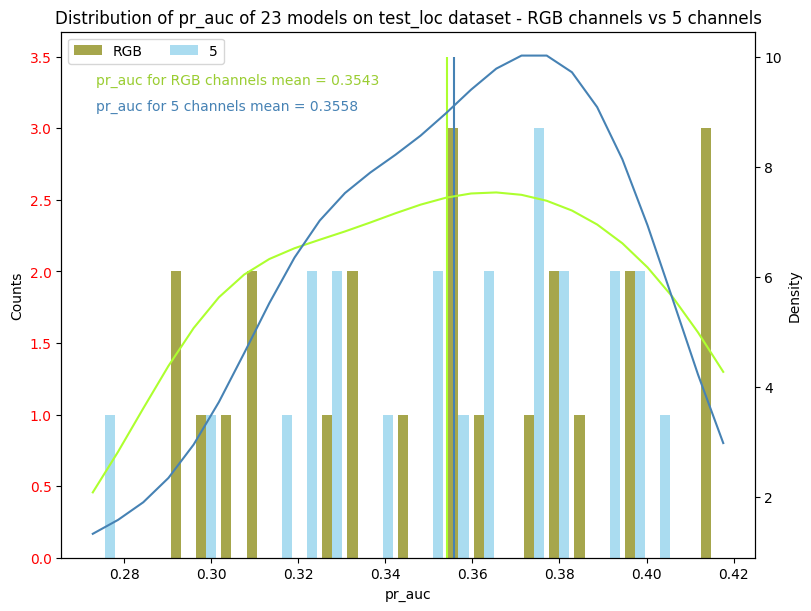

t-test for 5 vs RGB channels: t-statistic = -0.14, p value = 0.8891


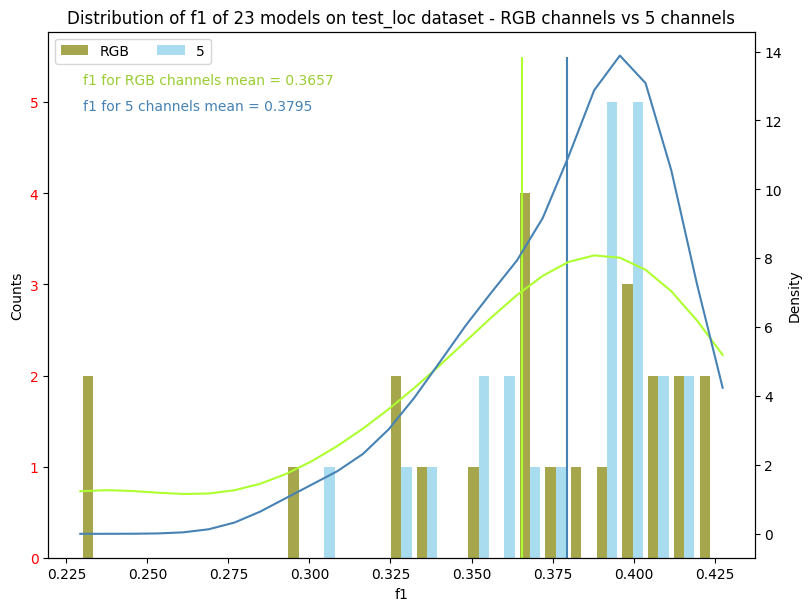

t-test for 5 vs RGB channels: t-statistic = -1.07, p value = 0.2887


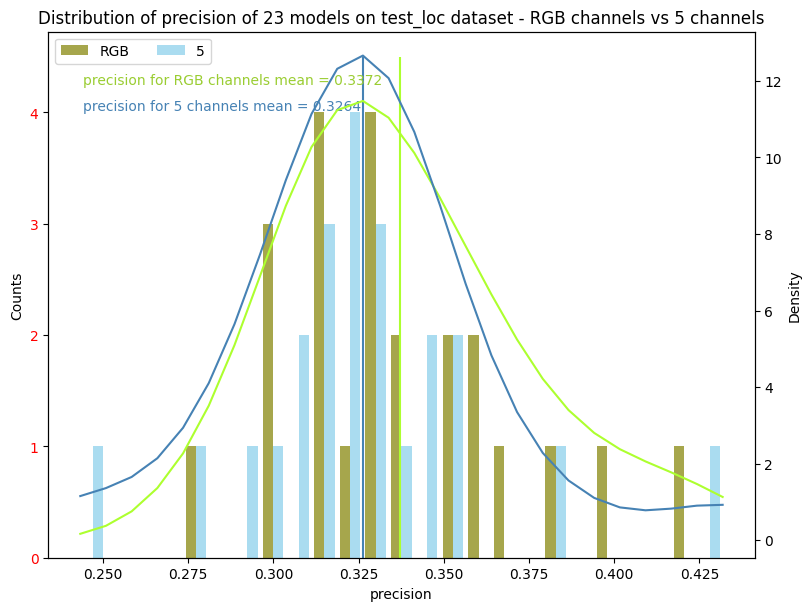

t-test for 5 vs RGB channels: t-statistic = 1.03, p value = 0.3065


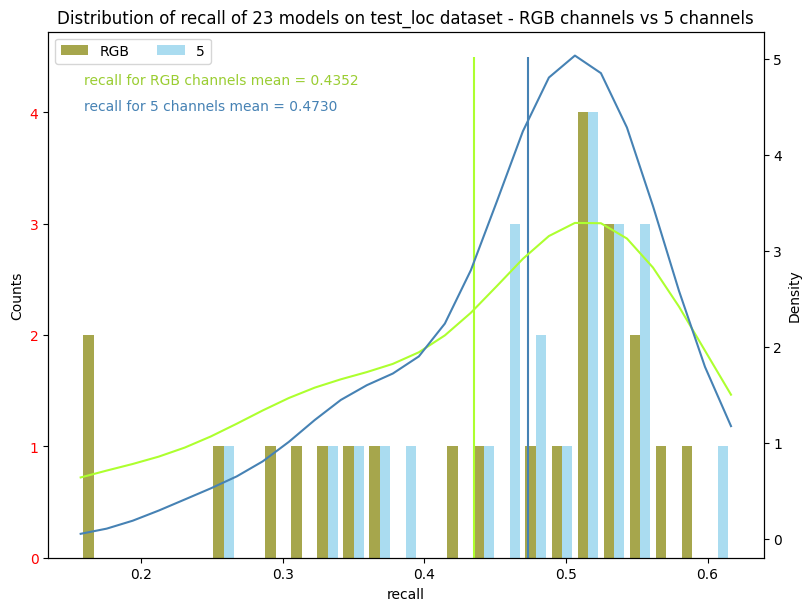

t-test for 5 vs RGB channels: t-statistic = -1.18, p value = 0.2442


In [77]:
plot(df_mean_metrics_all, ch1 = 'RGB', ch2 = '5', test_set = 'test_loc')